In [1]:
from transformers import BartForConditionalGeneration, BartConfig
from transformers import RobertaTokenizerFast
import torch
from torch.utils.data import DataLoader

from miditok import REMI, TokenizerConfig, TokSequence
from pathlib import Path

from models import MelCAT_base_tokens
from dataset_utils import LiveMelCATDataset, MelCATCollator

from torch.nn import CrossEntropyLoss
import torch.nn.functional as F

import os
import numpy as np
import csv

import symusic
import json

from tqdm import tqdm

import json2midi_utils as j2m
import pretty_midi as pm

MAX_LENGTH = 1024

roberta_tokenizer_midi = RobertaTokenizerFast.from_pretrained('/media/datadisk/data/pretrained_models/pop_midi_mlm_base/pop_wordlevel_tokenizer')

bart_config = BartConfig(
    vocab_size=roberta_tokenizer_midi.vocab_size,
    pad_token_id=roberta_tokenizer_midi.pad_token_id,
    bos_token_id=roberta_tokenizer_midi.bos_token_id,
    eos_token_id=roberta_tokenizer_midi.eos_token_id,
    decoder_start_token_id=roberta_tokenizer_midi.bos_token_id,
    forced_eos_token_id=roberta_tokenizer_midi.eos_token_id,
    max_position_embeddings=MAX_LENGTH,
    encoder_layers=8,
    encoder_attention_heads=16,
    encoder_ffn_dim=4096,
    decoder_layers=8,
    decoder_attention_heads=16,
    decoder_ffn_dim=4096,
    d_model=256,
    encoder_layerdrop=0.3,
    decoder_layerdrop=0.3,
    dropout=0.3
)

run_on_gpu = False

if run_on_gpu:
    dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = MelCAT_base_tokens(bart_config, gpu=0).to(dev)
    checkpoint = torch.load('saved_models/bart_base/bart_base.pt', weights_only=True)
else:
    dev = torch.device("cpu")
    model = MelCAT_base_tokens(bart_config, gpu=None).to(dev)
    checkpoint = torch.load('saved_models/bart_pop_tokens/bart_pop_tokens.pt', map_location="cpu", weights_only=True)

model.load_state_dict(checkpoint)

model.eval()

/home/maximos/anaconda3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/maximos/anaconda3/envs/torch/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


MelCAT_base_tokens(
  (bart_model): BartForConditionalGeneration(
    (model): BartModel(
      (shared): BartScaledWordEmbedding(180, 256, padding_idx=3)
      (encoder): BartEncoder(
        (embed_tokens): BartScaledWordEmbedding(180, 256, padding_idx=3)
        (embed_positions): BartLearnedPositionalEmbedding(1026, 256)
        (layers): ModuleList(
          (0-7): 8 x BartEncoderLayer(
            (self_attn): BartSdpaAttention(
              (k_proj): Linear(in_features=256, out_features=256, bias=True)
              (v_proj): Linear(in_features=256, out_features=256, bias=True)
              (q_proj): Linear(in_features=256, out_features=256, bias=True)
              (out_proj): Linear(in_features=256, out_features=256, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=256, out_features=4096, bias=True)
            (fc2): Linear(i

In [2]:
# prepare for competition
tmp_midis_folder = 'tmp_midis'
os.makedirs(tmp_midis_folder, exist_ok=True)
# make midis out of each json
json_inputs_folder = 'competition_test_inputs'
json_inputs = os.listdir( json_inputs_folder )
# make folder for json output
json_outputs_folder = 'competition_test_outputs'
os.makedirs(json_outputs_folder, exist_ok=True)
# make folder for midi total output
midi_outputs_folder = 'competition_test_midi_outputs'
os.makedirs(midi_outputs_folder, exist_ok=True)

In [ ]:
DEFAULT_V_MEL = 70
DEFAULT_V_ACC = 50
DEFAULT_V_CHD = 50

bpm = 120

for json_input in json_inputs:
    print(json_input)
    dict_input = j2m.load_json( os.path.join(json_inputs_folder, json_input) )
    melody_notes = j2m.note_list_to_notes(dict_input['melody'], default_v=DEFAULT_V_ACC, bpm=bpm)
    chord_notes = j2m.chord_list_to_notes(dict_input['chords'], default_v=DEFAULT_V_CHD, bpm=bpm)
    midi = pm.PrettyMIDI(initial_tempo=bpm)
    midi.instruments = [pm.Instrument(65, is_drum=False, name='melody'), 
                        pm.Instrument(0, is_drum=False, name='chords')
                        ]
    midi.instruments[0].notes = melody_notes
    midi.instruments[1].notes = chord_notes
    midi.write(os.path.join(tmp_midis_folder, json_input.split('.')[0] +'.mid'))

solar.json
lead_sheet_0.json
giant_steps.json


In [4]:
# midifolder = '/media/datadisk/datasets/POP909/aug_folder'
midifolder = 'tmp_midis'
# midifolder = '/media/datadisk/data/Giant_PIano/'
dataset = LiveMelCATDataset(midifolder, segment_size=40, resolution=4, max_seq_len=1024, only_beginning=True)

/home/maximos/anaconda3/envs/torch/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
dataset[2]['melody']

piece not long enough:  lead_sheet_0.mid
piece not trimmed


tensor([  5,  40, 112,   5,  40,  38, 107,  84,  58,  20, 107,  84,   5,  40,
         18, 107,  84,  58,  27, 107,  77,  74,  25, 107, 109,   5,   5,  40,
         18, 107,  77,  72,  22, 107,  90,   5,  40,  20, 107,  84,  58,  25,
        107,  84,   5,  40,  27, 107,  84,  58,  70, 107,  77,  74,  33, 107,
        109,   5,   5,  40,  27, 107,  84,  58,  36, 107,  77,  74,  25, 107,
          9])

In [6]:
custom_collate_fn = MelCATCollator(max_seq_lens=dataset.max_seq_lengths, padding_values=dataset.padding_values)
dataloader = DataLoader(dataset, batch_size=1, collate_fn=custom_collate_fn, drop_last=True)

In [7]:
custom_collate_fn([dataset[0]])

piece not long enough:  solar.mid
piece not trimmed


{'melody': {'input_ids': tensor([[  5,  40, 112,   5,  71,  19, 107,  77,  58,  18, 107,  23,  68,  20,
           107,   9,  74,  19, 107,   9,   5,  71,  27, 107,  93,  74,  22, 107,
             9,   5,  40,  25, 107,  21,  63,  25, 107,   6,  72,  25, 107,   9,
            58,  22, 107,  23,  68,  19, 107,   9,  74,  25, 107, 109,   5,   5,
            71,  22, 107,  77,  58,  30, 107,  23,  68,  25, 107,   9,  74,  22,
           107,   9,   5,  71,  80, 107,  90,  68,  36, 107,   9,  74,  27, 107,
             9,   5,  40,  30, 107,  21,  63,  30, 107,   6,  72,  30, 107,   9,
            58,  27, 107,  23,  68,  25, 107,   9,  74,  30, 107, 100]]),
  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [8]:
# i = 0
# for d in dataloader:
#     if i == 3:
#         break
#     i += 1
# print(i, d)
for d in dataloader:
    break

piece not long enough:  solar.mid
piece not trimmed


In [9]:
print(d['accomp']['input_ids'][0])
toks = roberta_tokenizer_midi.convert_ids_to_tokens(d['accomp']['input_ids'][0])
print(toks)

tensor([  5,  40, 112,   5,  40, 131, 107,  84, 115, 107,  84, 103, 107,  89,
         86, 107,  84,  83, 107,  84,  58, 145, 107,  84, 130, 107,  84, 121,
        107,  89, 103, 107,  89,  91, 107,  84,   5,  40, 142, 107,  84, 121,
        107,  89, 103, 107,  84,  99, 107,  84,  83, 107,  84,  58, 136, 107,
         84, 121, 107,  84, 106, 107,  84,  95, 107,  84,  86, 107,  89,   5,
         40, 149, 107, 101, 115, 107, 101,  99, 107, 101,  86, 107, 101,   5,
         40, 137, 107,  84, 130, 107,  89, 110, 107,  84,  99, 107,  84,  91,
        107,  89,  58, 145, 107,  84, 130, 107,  84, 121, 107,  89, 103, 107,
         89,  91, 107,  84,   5,  40, 142, 107,  84, 121, 107,  89, 103, 107,
         84,  99, 107,  84,  83, 107,  84,  58, 136, 107,  84, 121, 107,  89,
        106, 107,  84,  95, 107,  84,  86, 107,  89,   5,  40, 149, 107,  84,
        121, 107,  84, 115, 107,  84,  99, 107,  84,  86, 107,  89,  58, 141,
        107,  84, 125, 107,  84, 110, 107,  84, 103, 107,  89,  

In [27]:
print(d['melody']['input_ids'][0])
toks_m = roberta_tokenizer_midi.convert_ids_to_tokens(d['melody']['input_ids'][0])
print(toks_m)

tensor([  5,  40, 112,   5,  40,  38, 107,  84,  58,  20, 107,  84,   5,  40,
         18, 107,  84,  58,  27, 107,  77,  74,  25, 107, 109,   5,   5,  40,
         18, 107,  77,  72,  22, 107,  90,   5,  40,  20, 107,  84,  58,  25,
        107,  84,   5,  40,  27, 107,  84,  58,  70, 107,  77,  74,  33, 107,
        109,   5,   5,  40,  27, 107,  84,  58,  36, 107,  77,  74,  25, 107,
          9])
['Bar_None', 'Position_0', 'Tempo_125x0', 'Bar_None', 'Position_0', 'Pitch_78', 'Velocity_52', 'Duration_2x0x2', 'Position_16', 'Pitch_74', 'Velocity_52', 'Duration_2x0x2', 'Bar_None', 'Position_0', 'Pitch_71', 'Velocity_52', 'Duration_2x0x2', 'Position_16', 'Pitch_67', 'Velocity_52', 'Duration_1x2x4', 'Position_28', 'Pitch_70', 'Velocity_52', 'Duration_5x0x1', 'Bar_None', 'Bar_None', 'Position_0', 'Pitch_71', 'Velocity_52', 'Duration_1x2x4', 'Position_12', 'Pitch_69', 'Velocity_52', 'Duration_2x1x2', 'Bar_None', 'Position_0', 'Pitch_74', 'Velocity_52', 'Duration_2x0x2', 'Position_16', 'Pi

In [10]:
bos_input = {
    'input_ids' : torch.LongTensor([[roberta_tokenizer_midi.bos_token_id]]),
    'attention_mask' : torch.LongTensor([[1]])
}
output = model(d['melody'], d['chroma'], bos_input, None)
logits = output.logits

In [11]:
import matplotlib.pyplot as plt

torch.Size([1, 1, 180])


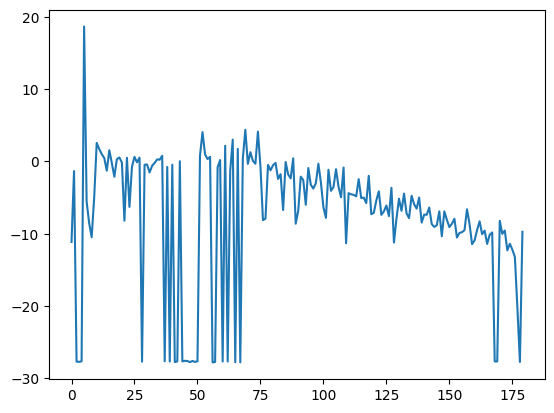

In [12]:
print(logits.shape)
plt.plot(logits[0,-1,:].cpu().detach().numpy())

torch.Size([1, 1, 180])


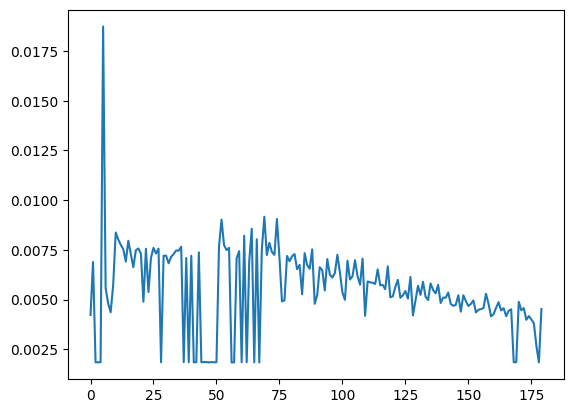

In [17]:
logits_softmax = F.softmax(logits, dim=-1)
print(logits_softmax.shape)
plt.plot(logits_softmax[0,-1,:].cpu().detach().numpy())

In [18]:
def sample_with_temperature(logits, temperature=1.0):
    # Scale logits by temperature
    logits = logits / temperature
    # Apply softmax to get probabilities
    probs = F.softmax(logits, dim=-1)

    # Flatten the logits if necessary
    batch_size, seq_len, vocab_size = probs.shape
    probs = probs.view(-1, vocab_size)  # Merge batch_size and seq_len dimensions
    
    # Sample from the probability distribution
    sampled_tokens = torch.multinomial(probs, num_samples=1)
    
    # Reshape back to [batch_size, seq_len, 1]
    sampled_tokens = sampled_tokens.view(batch_size, seq_len, 1)

    # # Sample from the probability distribution
    # sampled_token = torch.multinomial(probs, num_samples=1)
    return sampled_tokens

In [19]:
temperature = 0.7  # Adjust temperature as needed
sampled_tokens = sample_with_temperature(logits, temperature)
print(sampled_tokens[0][-1:])
print(bos_input['input_ids'])
xx = torch.cat( (bos_input['input_ids'].to(dev), sampled_tokens[0][-1:].to(dev)), -1 )

tensor([[5]])
tensor([[1]])


In [20]:
print(xx)

tensor([[1, 5]])


In [24]:
def generate_bart_tokens(d, temperature=1.0, max_seq_len=4096, num_bars=1000):
    accomp_input = {
        'input_ids' : torch.LongTensor([[roberta_tokenizer_midi.bos_token_id]]),
        'attention_mask' : torch.LongTensor([[1]])
    }
    bars_count = 0
    logits = model(d['melody'], d['chroma'], accomp_input, None).logits
    sampled_tokens = sample_with_temperature(logits, temperature)
    accomp_input['input_ids'] = torch.cat( (accomp_input['input_ids'].to(dev), sampled_tokens[0][-1:].to(dev)), -1)
    accomp_input['attention_mask'] = torch.cat( (accomp_input['attention_mask'].to(dev), torch.full(sampled_tokens[0][-1:].shape,1).to(dev)), -1)
    bars_count += sampled_tokens[0][-1][0] == 5
    while sampled_tokens[0][-1][0] != roberta_tokenizer_midi.eos_token_id and \
        accomp_input['input_ids'].shape[-1] < max_seq_len and\
        num_bars >= bars_count:
        print(accomp_input['input_ids'].shape[-1], 'bars_count:', bars_count, end='\r')
        logits = model(d['melody'], d['chroma'], accomp_input, None).logits
        sampled_tokens = sample_with_temperature(logits, temperature)
        # print(sampled_tokens[0][-1])
        bars_count += sampled_tokens[0][-1][0] == 5
        if num_bars < bars_count:
            break
        accomp_input['input_ids'] = torch.cat( (accomp_input['input_ids'].to(dev), sampled_tokens[0][-1:].to(dev)), -1)
        accomp_input['attention_mask'] = torch.cat( (accomp_input['attention_mask'].to(dev), torch.full(sampled_tokens[0][-1:].shape,1).to(dev)), -1)
    return accomp_input

In [25]:
a = generate_bart_tokens(d, temperature=1.5, max_seq_len=1024, num_bars=9)

tensor([[  1,   5,  40, 104,  72,  95,  31,   6,  55,  83,  13,   6,  58,  86,])
tensor([[  1,   5,  40, 104,  72,  95,  31,   6,  55,  83,  13,   6,  58,  86,
tensor([[  1,   5,  40, 104,  72,  95,  31,   6,  55,  83,  13,   6,  58,  86,
tensor([[  1,   5,  40, 104,  72,  95,  31,   6,  55,  83,  13,   6,  58,  86,
tensor([[  1,   5,  40, 104,  72,  95,  31,   6,  55,  83,  13,   6,  58,  86,
tensor([[  1,   5,  40, 104,  72,  95,  31,   6,  55,  83,  13,   6,  58,  86,
tensor([[  1,   5,  40, 104,  72,  95,  31,   6,  55,  83,  13,   6,  58,  86,
tensor([[  1,   5,  40, 104,  72,  95,  31,   6,  55,  83,  13,   6,  58,  86,
tensor([[  1,   5,  40, 104,  72,  95,  31,   6,  55,  83,  13,   6,  58,  86,
tensor([[  1,   5,  40, 104,  72,  95,  31,   6,  55,  83,  13,   6,  58,  86,
tensor([[  1,   5,  40, 104,  72,  95,  31,   6,  55,  83,  13,   6,  58,  86,
tensor([[  1,   5,  40, 104,  72,  95,  31,   6,  55,  83,  13,   6,  58,  86,
tensor([[  1,   5,  40, 104,  72,  95,  31,   6,  

In [23]:
print(a['input_ids'][0])
toks = roberta_tokenizer_midi.convert_ids_to_tokens(a['input_ids'][0])
print(toks)

tensor([  1,   5,  40,  97,   5,   5,   5,   5,   5,  55,  29,  14,  77,  52,
         24,  17,  77,   5,   5,  64,  22,  13,  21,   5,  55,  85,  31, 100,
         64,  78,  17,  84])
['<s>', 'Bar_None', 'Position_0', 'Tempo_60x71', 'Bar_None', 'Bar_None', 'Bar_None', 'Bar_None', 'Bar_None', 'Position_14', 'Pitch_76', 'Velocity_111', 'Duration_1x2x4', 'Position_30', 'Pitch_73', 'Velocity_105', 'Duration_1x2x4', 'Bar_None', 'Bar_None', 'Position_26', 'Pitch_69', 'Velocity_100', 'Duration_0x6x8', 'Bar_None', 'Position_14', 'Pitch_83', 'Velocity_127', 'Duration_3x1x2', 'Position_26', 'Pitch_81', 'Velocity_105', 'Duration_2x0x2']


In [19]:
remi_tokenizer = REMI(params=Path('/media/datadisk/data/pretrained_models/pop_midi_mlm_base/pop_REMI_BPE_tokenizer.json'))

In [20]:
toks_miditok = []
for tok in toks:
    if '_' in tok:
        toks_miditok.append(tok.replace('x','.'))
tok_seq = TokSequence(toks_miditok)

In [21]:
print(tok_seq)

TokSequence(tokens=['Bar_None', 'Position_0', 'Tempo_92.86', 'Position_4', 'Duration_0.2.8', 'Position_8', 'Pitch_76', 'Velocity_100', 'Duration_0.6.8', 'Position_24', 'Pitch_76', 'Velocity_95', 'Duration_0.4.8', 'Bar_None', 'Position_0', 'Pitch_72', 'Velocity_95', 'Duration_0.4.8', 'Position_8', 'Pitch_72', 'Velocity_95', 'Duration_0.2.8', 'Position_24', 'Pitch_72', 'Velocity_74', 'Duration_1.0.4', 'Pitch_69', 'Pitch_60', 'Velocity_79', 'Duration_0.6.8', 'Bar_None', 'Position_4', 'Pitch_74', 'Velocity_100', 'Duration_0.2.8', 'Position_8', 'Pitch_74', 'Velocity_100', 'Duration_0.6.8', 'Position_24', 'Pitch_74', 'Velocity_100', 'Duration_0.4.8', 'Bar_None', 'Position_16', 'Pitch_74', 'Velocity_105', 'Duration_0.4.8', 'Bar_None', 'Position_0', 'Pitch_67', 'Velocity_95', 'Duration_0.2.8', 'Pitch_72', 'Velocity_105', 'Duration_0.2.8', 'Pitch_74', 'Velocity_105', 'Duration_0.2.8', 'Pitch_79', 'Velocity_105', 'Duration_0.2.8', 'Position_8', 'Pitch_72', 'Velocity_116', 'Duration_1.0.4', 'Pitc

In [22]:
m = remi_tokenizer.tokens_to_midi(tokens=[tok_seq])

/tmp/ipykernel_5272/2386078323.py:1: UserWarning: miditok: The `tokens_to_midi` method had been renamed `decode`. It is now depreciated and will be removed in future updates.
  m = remi_tokenizer.tokens_to_midi(tokens=[tok_seq])


In [23]:
print(m)

Score(ttype=Tick, tpq=8, begin=0, end=262, tracks=1, notes=26, time_sig=1, key_sig=0, markers=0)


In [26]:
jmidi = {'acc': []}
track = m.tracks[0]
for note in track.notes:
    jmidi['acc'].append({
        'start': note.time / m.ticks_per_quarter,
        'pitch': note.pitch,
        'duration': note.duration / m.ticks_per_quarter
    })

In [44]:
# incorporate in input
dict_input['acc'] = jmidi['acc']

In [45]:
# save json
with open(os.path.join( json_outputs_folder, 'test_json_result.json'), 'w') as json_file:
    json.dump(dict_input, json_file)

In [46]:
dict_input.keys()

dict_keys(['melody', 'chords', 'acc'])

In [49]:
# make single midi with accompaniment
for json_input in json_inputs:
    melody_notes = j2m.note_list_to_notes(dict_input['melody'], default_v=DEFAULT_V_ACC, bpm=bpm)
    acc_notes = j2m.note_list_to_notes(dict_input['acc'], default_v=DEFAULT_V_ACC, bpm=bpm)
    midi = pm.PrettyMIDI(initial_tempo=bpm)
    midi.instruments = [pm.Instrument(65, is_drum=False, name='melody'), 
                        pm.Instrument(0, is_drum=False, name='acc')
                        ]
    midi.instruments[0].notes = melody_notes
    midi.instruments[1].notes = acc_notes
    midi.write(os.path.join(midi_outputs_folder, json_input.split('.')[0]+'_out' +'.mid'))

In [24]:
m.dump_midi("out.mid")

In [86]:
print(jmidi)

{'acc': [{'start': 2.5, 'pitch': 78, 'duration': 0.75}, {'start': 3.0, 'pitch': 80, 'duration': 0.75}, {'start': 3.0, 'pitch': 86, 'duration': 0.75}, {'start': 3.5, 'pitch': 83, 'duration': 0.5}, {'start': 3.5, 'pitch': 85, 'duration': 0.75}, {'start': 5.25, 'pitch': 80, 'duration': 0.5}, {'start': 5.25, 'pitch': 80, 'duration': 0.5}, {'start': 5.5, 'pitch': 75, 'duration': 0.5}, {'start': 5.5, 'pitch': 83, 'duration': 0.75}, {'start': 6.5, 'pitch': 78, 'duration': 0.75}, {'start': 8.0, 'pitch': 78, 'duration': 0.25}, {'start': 8.0, 'pitch': 88, 'duration': 0.25}, {'start': 10.5, 'pitch': 76, 'duration': 3.5}, {'start': 10.5, 'pitch': 86, 'duration': 4.0}, {'start': 18.5, 'pitch': 81, 'duration': 1.0}, {'start': 18.5, 'pitch': 85, 'duration': 1.0}, {'start': 19.5, 'pitch': 80, 'duration': 1.0}, {'start': 20.0, 'pitch': 74, 'duration': 2.5}, {'start': 22.5, 'pitch': 73, 'duration': 0.75}, {'start': 22.5, 'pitch': 81, 'duration': 3.5}, {'start': 22.5, 'pitch': 87, 'duration': 3.5}, {'sta

In [84]:
# m.time_signatures
# m.tempos[0]
m.tracks[0].notes[0]
# m.ticks_per_quarter

Note(time=20, duration=6, pitch=78, velocity=116, ttype='Tick')

In [ ]:
s = symusic.Score("out.mid")

In [ ]:
print(s)